In [246]:
import numpy as np
import pandas as pd
from pathlib import Path
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_embeddings(folder_path):
    embeddings = []

    for file in Path(folder_path).glob("*.npy"):
        embedding = np.load(str(file))
        embedding = embedding.astype(np.float32)
        embeddings.append(embedding)
    return torch.tensor(np.array(embeddings[0])).to(device)

def load_embeddings_map(file_path):
    embeddings_map = []

    for file in Path(file_path).glob("*.csv"):
        df = pd.read_csv(file, header=None)
        embeddings_map.append(df.values.tolist())
    return pd.Series(embeddings_map[0])

folder_path = 'data/embeddings'
embeddings = load_embeddings(folder_path)
embeddings_map = load_embeddings_map(folder_path)
embeddings_map = embeddings_map.apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x)
# embeddings_map = embeddings_map.apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x)

print(f"Embeddings shape: {embeddings.shape}")
print(f"Embeddings device: {embeddings.device}")
print(f"Embeddings map length: {len(embeddings_map)}")

Embeddings shape: torch.Size([10805, 512])
Embeddings device: cuda:0
Embeddings map length: 10805


In [247]:
import json
import numpy as np
from PIL import Image

def load_annotation(file_path):
    data = []

    with open (file_path, 'r', encoding="utf-8") as file:
        data = json.load(file)    
    return data

annotation_path = "data/vimmsd-train.json"
image_folder_path = "data/warmup-images"
data = load_annotation(annotation_path)

In [248]:
from sentence_transformers import SentenceTransformer, util
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
labels = ["sarcasm", "not-sarcasm"]
text_model = SentenceTransformer('sentence-transformers/clip-ViT-B-32').to(device)

def get_clip_cos_sim_score(image_embedding, label):
    text_embedding = text_model.encode(label, convert_to_tensor=True).to(device)
    image_embedding = image_embedding.to(device)
    score = util.cos_sim(text_embedding, image_embedding)
    return score[0].item()

def get_label(labels, image_embedding):
    result = []

    for i in range(len(labels)):
        label = labels[i]
        score = get_clip_cos_sim_score(image_embedding=image_embedding, label=map_clip_text_prompt(label))
        result.append([label, score])
    result = sorted(result, key = lambda item: item[-1])
    return result[-1]

def map_test_label(label):
    return label if (label == "not-sarcasm") else "sarcasm"

def map_label(label):
    return 1 if (label== "sarcasm") else 0

def map_clip_text_prompt(label):
    return "sarcasm" if (label=="sarcasm") else "not-sarcasm"

c:\Users\ADMIN\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


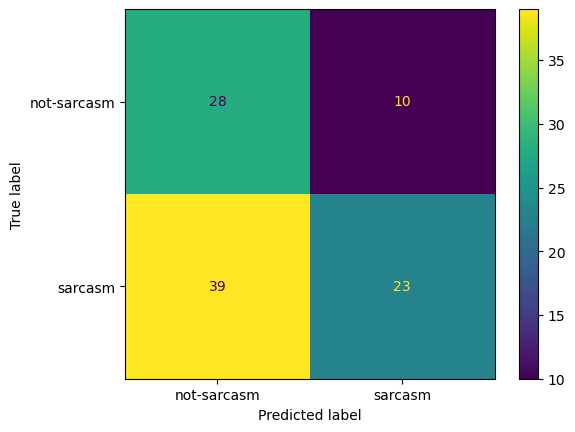

In [249]:
from sklearn import metrics
import collections
import matplotlib.pyplot as plt

labels = ["sarcasm", "not-sarcasm"]
labels_test = []
labels_predicted = []

for id in range(100):
    id = str(id)
    image_name = data[id]['image']
    label_test = map_test_label(data[id]['label'])
    
    embedding_id = embeddings_map.loc[embeddings_map == image_name].index
    result = get_label(labels, embeddings[embedding_id])
    label_predicted, score = result[0], result[1]
    labels_test.append(map_label(label_test))
    labels_predicted.append(map_label(label_predicted))
confusion_matrix = metrics.confusion_matrix(labels_test, labels_predicted)
counter = collections.Counter(labels_test)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["not-sarcasm", "sarcasm"])
cm_display.plot()
plt.show()